In [3]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip -d data

In [4]:
import os

fname = os.path.join('data/jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].replace('\"','').split(',')
lines = lines[1:]

print(len(lines))

420451


In [5]:
header

['Date Time',
 'p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [6]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [7]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [8]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [9]:
raw_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

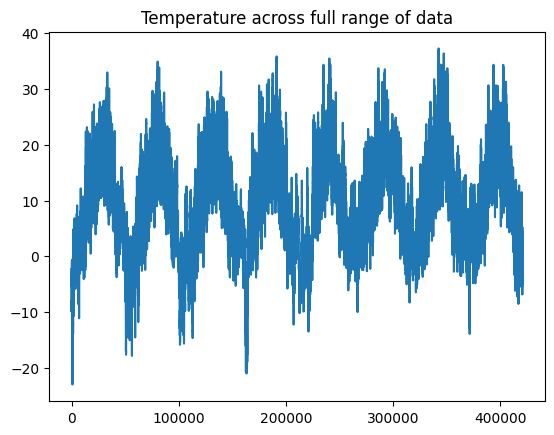

In [10]:
import matplotlib.pyplot as plt

plt.title('Temperature across full range of data')
plt.plot(range(len(temperature)), temperature)

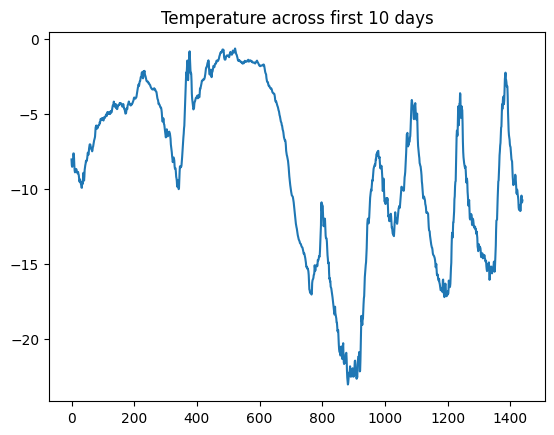

In [11]:
plt.title('Temperature across first 10 days')  
plt.plot(range(1440), temperature[:1440])         # 144 data points collected per day, for 10 days = 1440

In [12]:
# We use a 50-25-25 split for train-valid-test

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

num_train_samples, num_val_samples, num_test_samples

(210225, 105112, 105114)

In [13]:
# Problem: Given data over 5 days sampled once per hour, can we predict the temperature in 24 hours?

# Normalize the features independently

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean 
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
raw_data[0]

array([ 0.91365151, -1.92064015, -1.97449272, -1.86625827,  1.04801712,
       -1.29131928, -1.46715535, -0.78234525, -1.47012583, -1.4720352 ,
        2.12415558, -0.73016651, -0.77935289, -0.28119316])

### Side Note: Understanding `timeseries_dataset_from_array()`

In [15]:
from tensorflow import keras 

int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(data=int_sequence[:-3],               # Sequences generated will be sampled from [0, 1, 2, 3, 4, 5, 6]
                                                          targets=int_sequence[3:],             # Target for a sequence starting at data[n] will be data[n + 3]
                                                          sequence_length=3,                    # Sequences will be 3 steps long
                                                          batch_size=2)                         # Sequences will be batched into batches of size 2

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2023-12-14 11:01:05.643785: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-14 11:01:05.643809: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-12-14 11:01:05.643816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-12-14 11:01:05.643849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 11:01:05.643869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Back to problem: Create datasets

In [16]:
sampling_rate = 6                                         # We only consider one data point out of 6. Dataset is recorded every 10 minutes. We sample one per hour, i.e. 60 mins
sequence_length = 120                                     # Observations will go back 5 days (120 hours)
delay = sampling_rate * (sequence_length + 24 - 1)        # Target for a sequence will be the temperature 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(data=raw_data[:-delay],
                                                          targets=temperature[delay:],
                                                          sampling_rate=sampling_rate,
                                                          sequence_length=sequence_length,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          start_index=0,
                                                          end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(data=raw_data[:-delay],
                                                          targets=temperature[delay:],
                                                          sampling_rate=sampling_rate,
                                                          sequence_length=sequence_length,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          start_index=num_train_samples,
                                                          end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(data=raw_data[:-delay],
                                                          targets=temperature[delay:],
                                                          sampling_rate=sampling_rate,
                                                          sequence_length=sequence_length,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          start_index=num_train_samples + num_val_samples)

In [17]:
len(train_dataset), len(val_dataset), len(test_dataset)

(819, 408, 405)

In [18]:
# samples: 14 features, across last 5 days (120 hours), batched into 256
# targets: 256 temperature values 24 hours after

for samples, targets in train_dataset:
    print('Samples shape:', samples.shape)
    print('Targets shape:', targets.shape)
    break

Samples shape: (256, 120, 14)
Targets shape: (256,)


In [19]:
# Setting the common sense baseline: temperature is same after 24 hours as it is at the moment
# Calculating the common sense baseline MAE

def evaluate_naive_method(dataset, mean, std):
    total_abs_error = 0.
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    
    return total_abs_error / samples_seen

In [20]:
# Interpret this as "If we always assume temperature to be the same as the previous day, we will be, on average, off by about 2.5 degrees Celsius"

print(f'Validation MAE: {evaluate_naive_method(val_dataset, mean, std):.2f}')
print(f'Test MAE: {evaluate_naive_method(test_dataset, mean, std):.2f}')

Validation MAE: 2.44
Test MAE: 2.62


In [21]:
# Setting a simple Machine Learning baseline: cheap and simple models

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation=activations.relu)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint('ckpts/jena_dense.keras', save_best_only=True)]

model.compile(optimizer=optimizers.RMSprop(), loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10


2023-12-14 11:01:13.322791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 13s 15ms/step - loss: 73.1993 - mean_absolute_error: 7.0357 - val_loss: 55.3112 - val_mean_absolute_error: 5.8625
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 46.1395 - mean_absolute_error: 4.9105 - val_loss: 12.9627 - val_mean_absolute_error: 2.8496
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 47.7680 - mean_absolute_error: 4.7259 - val_loss: 25.4575 - val_mean_absolute_error: 4.0410
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 46.0712 - mean_absolute_error: 4.7717 - val_loss: 15.4944 - val_mean_absolute_error: 3.1476
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 44.7642 - mean_absolute_error: 4.8444 - val_loss: 43.6415 - val_mean_absolute_error: 5.4167
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 46.4091 - mean_absolute_error: 5.1262 - val_loss: 34.3455 - val_mean_absolute_error: 4.7695
Epo

In [23]:
model = keras.models.load_model('ckpts/jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 4s 9ms/step - loss: 15.5320 - mean_absolute_error: 3.0897
Test MAE: 3.09


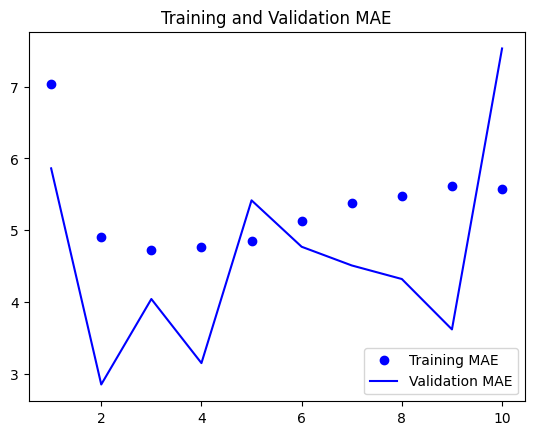

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history[list(history.history.keys())[0]]) + 1)

plt.figure()
plt.plot(epochs, history.history['mean_absolute_error'], 'bo', label='Training MAE')
plt.plot(epochs, history.history['val_mean_absolute_error'], 'b-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

In [25]:
# Setting a second Machine Learning baseline: Conv1D models

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation=activations.relu)(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation=activations.relu)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation=activations.relu)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('ckpts/jena_conv.keras', save_best_only=True)]

model.compile(optimizer=optimizers.RMSprop(), loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 15s 18ms/step - loss: 21.0769 - mean_absolute_error: 3.6006 - val_loss: 14.8527 - val_mean_absolute_error: 3.0460
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.2306 - mean_absolute_error: 3.0949 - val_loss: 14.5103 - val_mean_absolute_error: 2.9986
Epoch 3/10
819/819 [==============================] - 14s 18ms/step - loss: 14.0558 - mean_absolute_error: 2.9713 - val_loss: 14.8853 - val_mean_absolute_error: 3.0353
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.1353 - mean_absolute_error: 2.8661 - val_loss: 17.8422 - val_mean_absolute_error: 3.3708
Epoch 5/10
819/819 [==============================] - 14s 18ms/step - loss: 12.4305 - mean_absolute_error: 2.7838 - val_loss: 14.6007 - val_mean_absolute_error: 2.9968
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 11.8821 - mean_absolute_error: 2.7180 - val_loss: 16.4552 - val_mean_absolute_error:

In [26]:
model = keras.models.load_model('ckpts/jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 4s 10ms/step - loss: 14.7402 - mean_absolute_error: 3.0365
Test MAE: 3.04


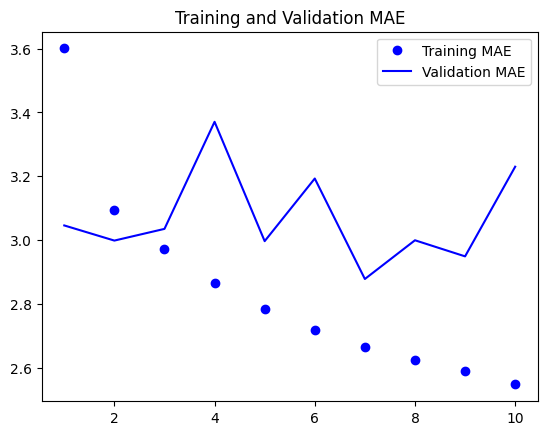

In [27]:
epochs = range(1, len(history.history[list(history.history.keys())[0]]) + 1)

plt.figure()
plt.plot(epochs, history.history['mean_absolute_error'], 'bo', label='Training MAE')
plt.plot(epochs, history.history['val_mean_absolute_error'], 'b-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

### What went wrong?

1. Weather data does not respect the translation invariance assumption of a 1D ConvNet. Data from morning follows different properties from data at night. Weather data is only translation invariant for a very specific timescale.
2. Recent weather data is much more indicative of future weather data than data from the past. 1D ConvNet is not able to leverage this fact. MaxPooling and GlobalAverage Pooling is essentially destroying the order information.

In [28]:
# Setting a third Machine Learning baseline: basic LSTM recurrent nets

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('ckpts/jena_lstm.keras', save_best_only=True)]

model.compile(optimizer=optimizers.RMSprop(), loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 27s 31ms/step - loss: 39.4672 - mean_absolute_error: 4.5615 - val_loss: 11.8140 - val_mean_absolute_error: 2.6388
Epoch 2/10
819/819 [==============================] - 25s 31ms/step - loss: 11.1141 - mean_absolute_error: 2.5835 - val_loss: 9.5780 - val_mean_absolute_error: 2.4136
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 9.8258 - mean_absolute_error: 2.4415 - val_loss: 9.7674 - val_mean_absolute_error: 2.4335
Epoch 4/10
819/819 [==============================] - 25s 31ms/step - loss: 9.3314 - mean_absolute_error: 2.3825 - val_loss: 9.5744 - val_mean_absolute_error: 2.4090
Epoch 5/10
819/819 [==============================] - 25s 31ms/step - loss: 9.0515 - mean_absolute_error: 2.3467 - val_loss: 9.5451 - val_mean_absolute_error: 2.4009
Epoch 6/10
819/819 [==============================] - 26s 31ms/step - loss: 8.8468 - mean_absolute_error: 2.3217 - val_loss: 9.6318 - val_mean_absolute_error: 2.4074
E

In [29]:
model = keras.models.load_model('ckpts/jena_lstm.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 4s 10ms/step - loss: 10.9022 - mean_absolute_error: 2.5790
Test MAE: 2.58


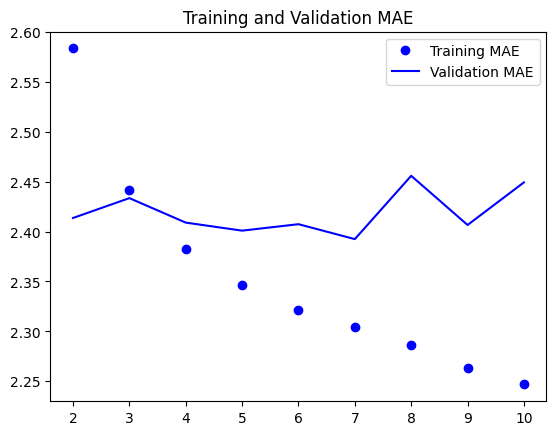

In [30]:
# Visualizing MAE without epoch 1, which has high MAE and would distort the graph

epochs = range(2, len(history.history[list(history.history.keys())[0]]) + 1)

plt.figure()
plt.plot(epochs, history.history['mean_absolute_error'][1:], 'bo', label='Training MAE')
plt.plot(epochs, history.history['val_mean_absolute_error'][1:], 'b-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

## RNN Deep Dive

In [31]:
# Pseudocode for RNN forward pass

input_sequence = []
state_t = 0
def forward(input_t, state_t):
    def activation(x):pass
    def dot(x, y):pass
    return activation(dot(W, input_t) + dot(U, state_t) + b)

for input_t in input_sequence:
    output_t = forward(input_t, state_t)
    state_t = output_t

In [32]:
# Naive numpy implementation of a forward pass of an RNN
# Corresponds to keras.layers.SimpleRNN, except that implementation considers batches, inputs_shape = (batch_size, timesteps, input_features))
# Setting timesteps = None enables processing sequences of arbitrary lengths, albeit being less performant and model.summary() not showing complete shapes

import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))        # (100, 32)
state_at_timestep_t = np.zeros((output_features,))            # (64,)
W = np.random.random((output_features, input_features))       # (64, 32)
U = np.random.random((output_features, output_features))      # (64, 64)
b = np.random.random((output_features,))                      # (64,)
successive_outputs = []
activation = np.tanh

for input_at_timestep_t in inputs:
    output_at_timestep_t = activation(np.dot(W, input_at_timestep_t) + np.dot(U, state_at_timestep_t) + b)     # (64, 32).(32,) + (64, 64).(64,) + (64,) = (64,)
    successive_outputs.append(output_at_timestep_t)                                   
    state_at_timestep_t = output_at_timestep_t

final_output_sequence = np.stack(successive_outputs, axis=0)               # (100, 64) (same as just converting the list into an array)
final_output_sequence.shape

(100, 64)

In [33]:
# return_sequences argument can be used to specify whether or not to return outputs at every time step
# all outputs may not be necessary as subsequent outputs already have information about previous outputs

num_features = 14
steps = 120

inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 16)
(None, 120, 16)


In [34]:
# When stacking several RNN's, it is useful to return sequences to have maximum representational power of the network

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16, return_sequences=False)(x)
outputs.shape

TensorShape([None, 16])

In [35]:
# LSTM's contain a carry data that is also propagated forward
# Pseudocode:

input_sequence = []
state_t = 0
carry_t = 0

def forward(input_t, state_t, carry_t):
    def activation(x):pass
    def dot(x, y):pass
    output_t = activation(dot(input_t, W_o) + dot(state_t, U_o) + dot(carry_t, V_o) + b)
    i_t = activation(dot(input_t, W_i) + dot(state_t, U_i) + b_i)
    f_t = activation(dot(input_t, W_f) + dot(state_t, U_f) + b_f)
    k_t = activation(dot(input_t, W_k) + dot(state_t, U_k) + b_k)
    carry_next = i_t * k_t + carry_t * f_t 

    return output_t, carry_next

for input_t in input_sequence:
    output_t, carry_t = forward(input_t, state_t, carry_t)
    state_t = output_t

In [51]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
inputs.shape

TensorShape([None, 120, 14])

## Regularization in Recurrent Nets: Recurrent Dropout

In [ ]:
# Recurrent dropout drops the same network units for every step of an unrolled recurrent net, i.e. the dropped out units do not change temporally per sequence

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)                                # A regular Dropout layer for the Dense layer
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint('ckpts/jena_lstm_dropout.keras', 
                                             save_best_only=True)]

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError()])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [55]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = keras.callbacks.ModelCheckpoint('ckpts/jena_stacked_gru_dropout.keras',
                                            save_best_only=True)

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError()])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
model = keras.models.load_model('ckpts/jena_stacked_gru_dropout.keras')
print(f'Test MAE: {model.evaluate(test_dataset[1]):.2f}')

### Bidirectional RNN

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAverageError()])

callbacks = keras.callbacks.ModelCheckpoint('ckpts/jena_bidirectional_lstm.keras',
                                            save_best_only=True)

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)